# Prognozowanie szeregów czasowych

In [174]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Naszą główną biblioteką do szeregów czasowych będzie [sktime](https://www.sktime.net/en/stable/index.html), oferujące interfejs podobny do Scikit-learn. Jest to wrapper na wiele innych bibliotek, między innymi:
- [statsforecast](https://github.com/Nixtla/statsforecast) - wydajna implementacja wielu metod prognozowania, m.in. AutoARIMA i AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - testy statystyczne dla szeregów czasowych oraz alternatywna implementacja AutoARIMA
- [statsmodels](https://www.statsmodels.org/stable/index.html) - niektóre metody dekompozycji szeregów czasowych i prognozowania

Do obliczania testów statystycznych wykorzystamy [scipy](https://docs.scipy.org/doc/scipy/index.html) oraz [statsmodels](https://www.statsmodels.org/stable/index.html).

## Prognozowanie inflacji w Polsce

Problem przewidywania inflacji (wskaźników cen towarów i usług konsumpcyjnych) jest bardzo powszechny, i wykonuje go zasadniczo każde państwo i większa instytucja finansowa. W praktyce jest to cała grupa interesujących problemów, bo mamy inflację, inflację bazową (po wyłączeniu najbardziej zmiennych czynników, np. cen żywności), 

W Polsce podstawowe dane o inflacji [publikuje Główny Urząd Statystyczny (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), z częstotliwością miesięczną, kwartalną, półroczną i roczną. Bardziej szczegółowe informacje publikują inne instytucje, bo zależą od przyjętej metodyki, np. inflację bazową [oblicza i publikuje Narodowy Bank Polski (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Prognozowanie inflacji jest wyzwaniem, bo typowo inflacja:
- ma wyraźne cykle, ale wysoce nieregularne
- jest implicite związana z wieloma czynnikami zewnętrznymi (gospodarka światowa, decyzje polityczne etc.)
- nie ma wyraźnej sezonowości
- interesuje nas prognozowanie na wielu poziomach szczególowości, np. miesięczne, kwartalne, roczne

Zajmiemy się danymi z GUS, o częstotliwości miesięcznej. Aby otrzymać inflację rok do roku (RDR), z którą typowo mamy do czynienia, trzeba odjąć 100 od podawanych wartości.

In [175]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100
df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2023-11      6.6
2023-12      6.2
2024-01      3.7
2024-02      2.8
2024-03      2.0
Freq: M, Name: value, Length: 507, dtype: float64

Do rysowania szeregów czasowych najłatwiej użyć funkcji `plot_series` z sktime, która ustawi nam od razu ładnie opisy na osi X.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

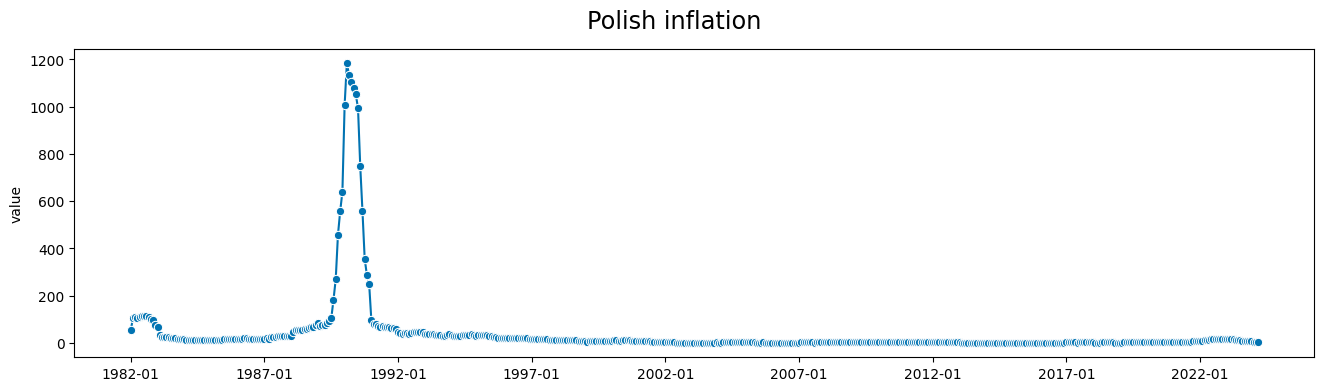

In [176]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

Tu nie ma błędu - lata 90 były ciekawym okresem, z [hiperinflacją](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), późniejszą [terapią szokową](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) i realizacją [planu Balcerowicza](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). Z perspektywy prognozowania szeregów czasowych jest to ewidentny outlier, ale przy tym bardzo długi. W związku z tym ograniczymy się do późniejszego okresu, od roku 2000.

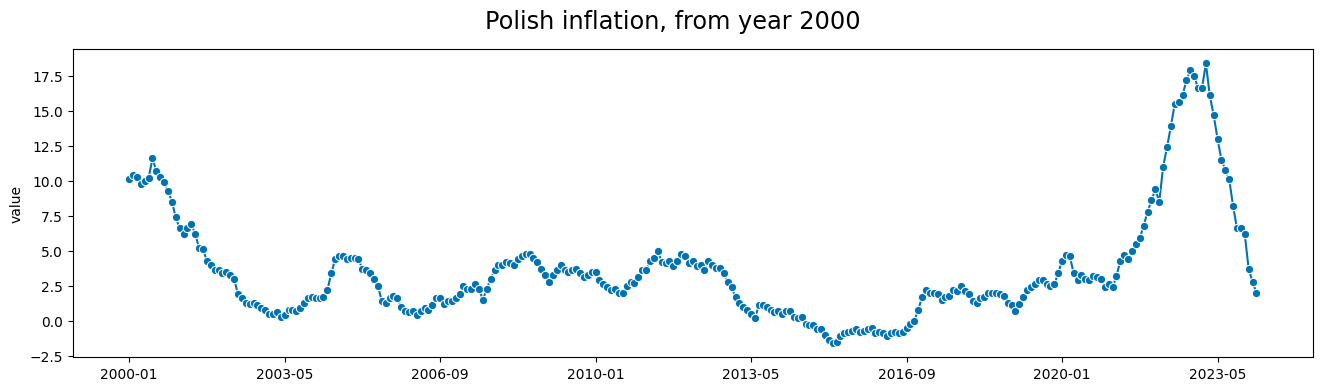

In [177]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000");

Już "na oko" widać tutaj ewidentne cykle i trendy. Natomiast są też dobre wieści - inflacja jest dość łagodnie zmiennym agregatem. Pytanie, co z sezonowością?

**Zadanie 1 (0.5 punktu)**

Uzupełnij kod funkcji `plot_stl_decomposition`. Wykorzystaj `STLTransformer` do obliczenia dekompozycji STL ([dokumentacja](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Pamiętaj o podaniu odpowiednich opcji, aby uwzględnić podany okres sezonowości, i zwrócić wszystkie trzy komponenty.

Następnie narysuj dekompozycję STL dla danych o inflacji. Skomentuj:
- czy twoim zdaniem widać tutaj roczną sezonowość?
- czy rezydua są białym szumem, czy widać tam jeszcze jakieś informacje do wykorzystania?

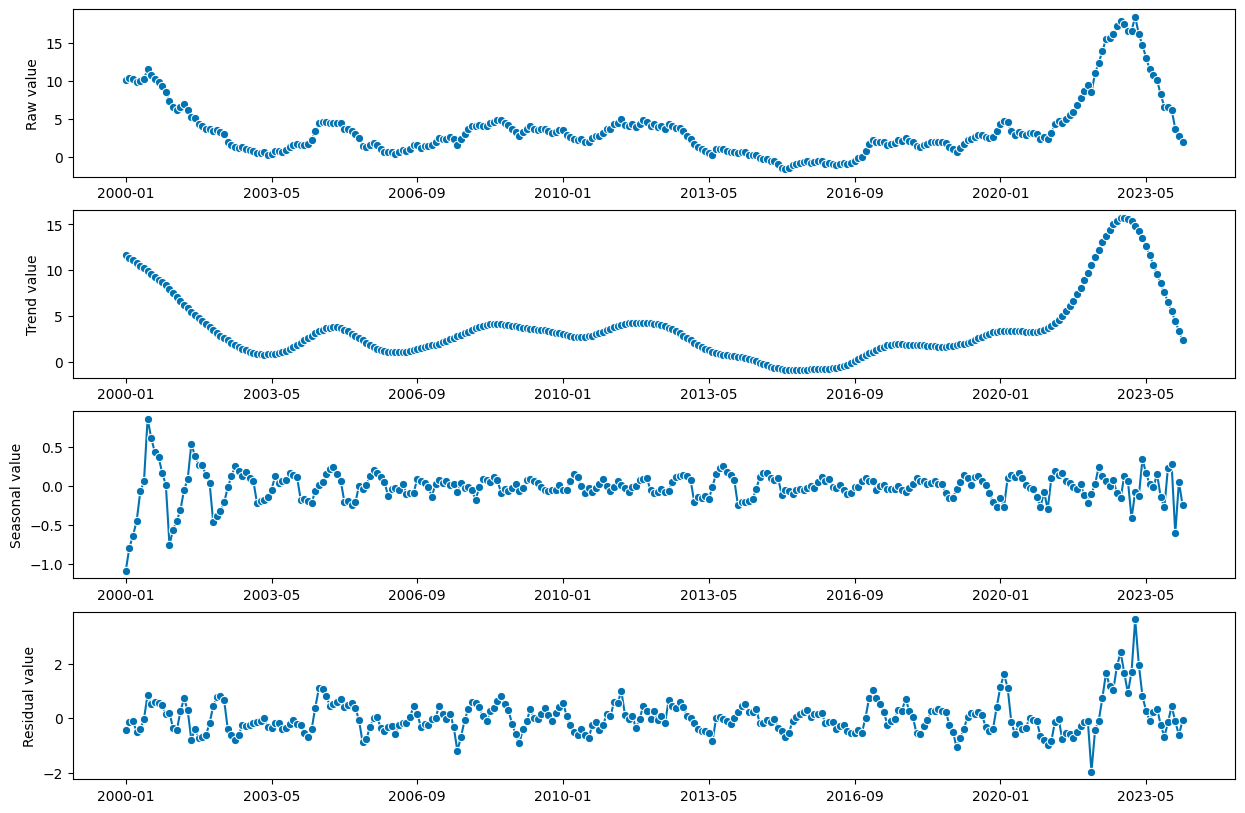

In [178]:
from sktime.transformations.series.detrend import STLTransformer


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    transformer = STLTransformer(sp=seasonal_period)
    transformer.fit(data)

    fig, axs = plt.subplots(4, figsize=(15, 10))

    # plot series, trend, seasonality and residuals in subplots
    plot_series(data, ax=axs[0])
    plot_series(transformer.trend_, ax=axs[1])
    plot_series(transformer.seasonal_, ax=axs[2])
    plot_series(transformer.resid_, ax=axs[3])

    axs[0].set_ylabel("Raw value")
    axs[1].set_ylabel("Trend value")
    axs[2].set_ylabel("Seasonal value")
    axs[3].set_ylabel("Residual value")

    fig.show()


plot_stl_decomposition(df, seasonal_period=12);

// skomentuj tutaj

Rezydua raczej nie są białym szumem, gdyż można zauważyć pewne regularności w przebiegu.

Metoda "na oko" z dekompozycją STL jest ważna - to pozwala nabrać intuicji i wiedzy co do danych, i walidować parametry. Ale od tego są procedury automatyczne, z testami statystycznymi, żeby nie trzeba było tak ręcznie.

Sprawdźmy teraz, jak wygląda kwestia sezonowości i stacjonarności. Nie jest to stricte potrzebne dla modeli ETS - one przyjmują dane as-is. Natomiast dla modeli ARIMA jest to już niezbędne, bo wymagają danych stacjonarnych, a wiedza o sezonowości potrafi bardzo przyspieszyć obliczenia (SARIMA jest dużo wolniejsza).

**Zadanie 2 (0.75 punktu)**

1. Sprawdź za pomocą testów statystycznych dla sezonowości, czy w danych występuje sezonowość kwartalna, półroczna lub roczna. Przyda się funkcja `nsdiffs` z biblioteki pmdarima. Jeżeli wykryto sezonowość, to usuń ją z pomocą klasy `Differencer` z sktime ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) oraz narysuj wartości na wykresie.

2. Sprawdź za pomocą testów statystycznych dla stacjonarności, jaki rząd różnicowania stacjonaryzuje szereg. Przyda się funkcja `ndiffs` z biblioteki pmdarima. Jeżeli jest większy niż zero, to usuń stacjonarość za pomocą klasy `Differencer` i narysuj wykres wartości po różnicowaniu.

3. Skomentuj, z jakiego wariantu modeli ARIMA byś skorzystał i dlaczego, na podstawie obecnej wiedzy: ARMA, ARIMA czy SARIMA.

Skorzystaj z domyślnych wartości `D_max` oraz `d_max`.

**Uwaga:** stwórz tutaj nowe zmienne dla wartości po różnicowaniu, nie nadpisuj `df`. Jeszcze nam się przyda.

Differencing 1


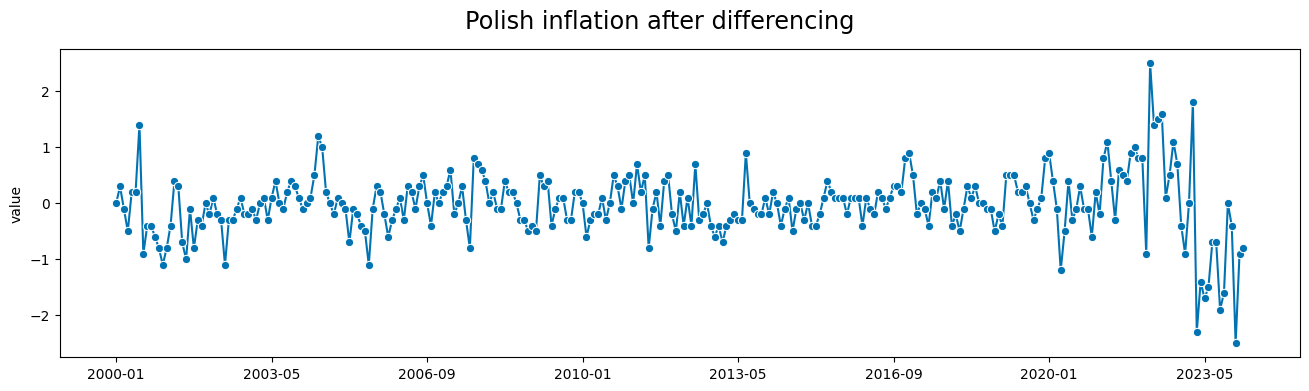

In [179]:
from pmdarima.arima import ndiffs, nsdiffs
from sktime.transformations.series.difference import Differencer

df_diff = df.copy()

# Seasonal dfifferencing
for m in [3, 6, 12]:
    if (D := nsdiffs(df, m)) > 0:
        print(f"Seasonal Differencing {m},{D}")
        df_diff = Differencer(lags=[m for _ in range(D)]).fit_transform(df_diff)

# Differencing
if (d := ndiffs(df)) > 0:
    print(f"Differencing {d}")
    df_diff = Differencer(lags=[1 for _ in range(d)]).fit_transform(df)

plot_series(df_diff, title="Polish inflation after differencing");

// skomentuj tutaj

Ponieważ aby uzyskać stacjonarny szereg musimy różnicować, więc na pewno nie możemy użyć modelu
ARMA. Dodatkowo ponieważ na podstawie testów statystycznych nie mamy w danych sezonowość, więc
najlepiej byłoby użyć modelu ARIMA.

Jesteśmy już zasadniczo gotowi do treningu modeli. Do testowania wykorzystamy 20% najnowszych danych, ze strategią expanding window, i krokiem 1 (bo mamy odczyty inflacji co miesiąc). Naszymi metrykami będą MAE, SMAPE oraz MASE.

Wykonamy też analizę rezyduów. Błędy powinny mieć rozkład normalny (model bez biasu) oraz nie mieć autokorelacji (model wykorzystujący całą wiedzę). Na potrzeby wszystkich testów statystycznych zakładamy poziom istotności $\alpha = 0.05$.

Wykorzystamy test normalności Anderson-Darling, bo jest nieco "luźniejszy" niż test Shapiro-Wilk, co jest przydatne w praktyce - błędy rzadko kiedy są bardzo blisko rozkładu normalnego. Hipotezą zerową jest, że wartości pochodzą z danego rozkładu (domyślnie normalnego), a alternatywną, że z jakiegoś innego.

Dla testowania autokorelacji błędów użyjemy testu Ljung-Box, który testuje autokorelację błędów dla różnych lagów. Dla każdego laga ma osobny test, w którym hipotezą zerową jest brak autokorelacji, a hipotezą alternatywą autokorelacja błędów dla danego opóźnienia.

**Zadanie 3 (1.5 punktu)**

Uzupełnij kod funkcji `evaluate_model`:
1. Stwórz `ExpandingWindowSplitter` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), który zacznie swoje działanie od 80% danych. Wielkość okna wyznacza argument `horizon`.
2. Stwórz listę metryk składającą się z MAE, SMAPE oraz MASE, z biblioteki sktime.
3. Przeprowadź ewaluację modelu za pomocą funkcji `evaluate` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Przekaż `return_data=True`, żeby zwrócić też obliczone predykcje. Zwraca ona DataFrame z wynikami.
4. Oblicz średnie wartości metryk z wynikowego DataFrame'a. Wypisz je zaokrąglone do 2 miejsc po przecinku.
5. Uwzględniając argument `analyze_residuals`, przeprowadź analizę błędów:
   - oblicz rezydua jako $y - \hat{y}$
   - narysuj histogram rezyduów
   - wykonaj test Anderson-Darling z biblioteki `scipy` i wypisz, czy rozkład jest normalny, czy nie
   - przetestuj test Ljung-Box z biblioteki `statsmodels` i wypisz wyniki testu

Następnie przetestuj tę funkcję na dwóch baseline'ach: średniej oraz ostatniej znanej wartości. Skorzystaj z klasy `NaiveForecaster` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), i horyzontu czasowego 3 miesięcy. Narysuj też wykresy predykcji.

In [180]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from sktime.split.expandingwindow import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox


def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(fh=horizon, initial_window=int(0.8 * data.size), step_length=1)
    metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(symmetric=True), MeanAbsoluteScaledError()]
    results = evaluate(forecaster=model, cv=cv, y=data, scoring=metrics, return_data=True)

    # extract and print metrics
    mae = results["test_MeanAbsoluteError"]
    smape = results["test_MeanAbsolutePercentageError"]
    mase = results["test_MeanAbsoluteScaledError"]
    print(f"MAE: {mae.mean():.2f} | SMAPE: {smape.mean():.2f} | MASE: {mase.mean():.2f}")

    y_pred = pd.concat(results["y_pred"].values)

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.show()

    if analyze_residuals:
        y_true = data[y_pred.index]
        resid = y_true - y_pred
        resid.plot.hist(bins=15, xlabel="Residual")

        print(
            f"""
Anderson-Darling test for normal distribution: {(res:=anderson(resid, dist="norm")).statistic:.2f}
Assuming significance level of 5% distribution is {'not normal' if res.statistic > res.critical_values[2] else 'normal'}
"""
        )

        print("Ljung-Box test for autocorrelation in residuals\n", acorr_ljungbox(data))

MAE: 2.27 | SMAPE: 0.32 | MASE: 6.64


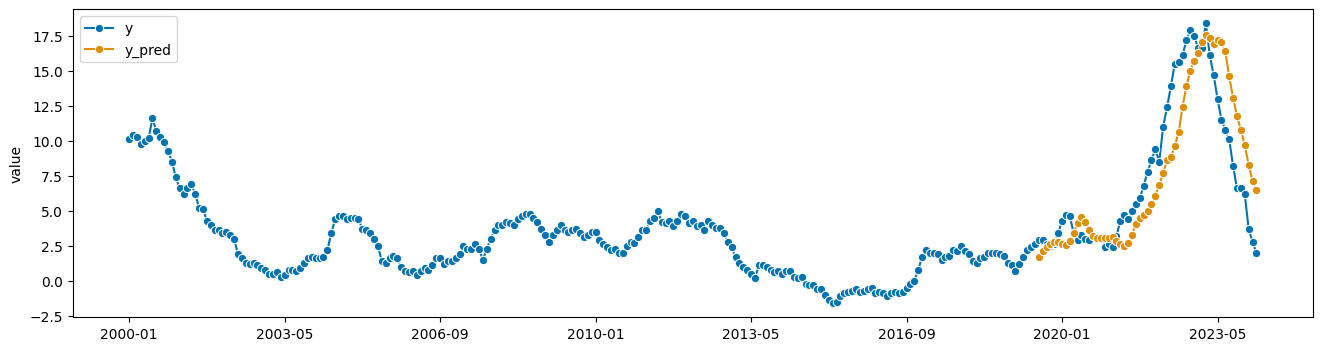

In [181]:
from sktime.forecasting.naive import NaiveForecaster

fcr_mean = NaiveForecaster(strategy="mean", window_length=3)
evaluate_model(model=fcr_mean, data=df, horizon=3, plot_forecasts=True, analyze_residuals=False);

MAE: 1.85 | SMAPE: 0.27 | MASE: 5.45


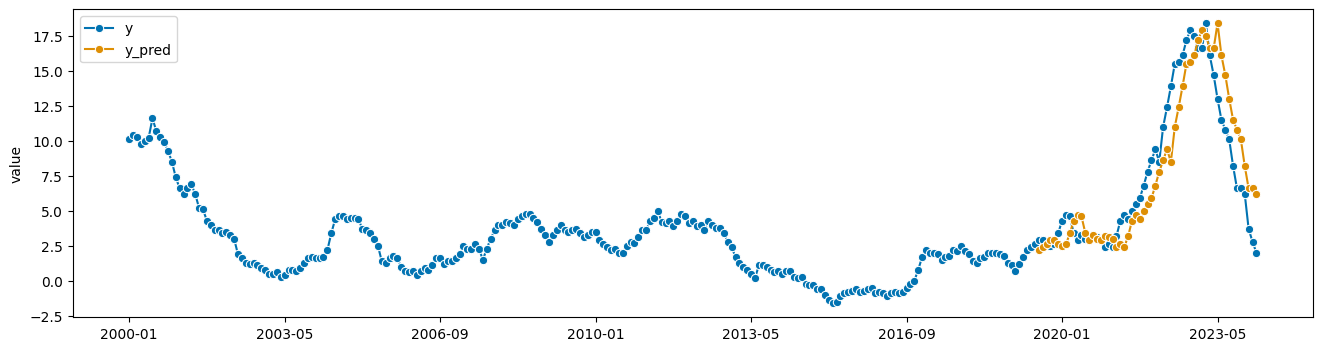

In [182]:
fcr_last = NaiveForecaster(strategy="last")
evaluate_model(model=fcr_last, data=df, horizon=3, plot_forecasts=True, analyze_residuals=False)

Mamy już pierwsze baseline'y, wyniki z nich wyglądają dość solidnie. Zobaczmy, czy ETS albo ARIMA będą w stanie je przebić.

**Zadanie 4 (0.75 punktu)**

1. Dokonaj predykcji algorytmem AutoETS (klasa `StatsForecastAutoETS`), w wariancie damped trend. Narysuj też predykcje i dokonaj analizy błędów.
2. Analogicznie, dokonaj predykcji algorytmem AutoARIMA (klasa `StatsForecastAutoARIMA`). Jeżeli nie wykryto wcześniej sezonowości, to przekaż odpowiednią opcję, żeby ją wyłączyć - SARIMA jest dużo wolniejsza niż ARIMA.
3. Skomentuj wyniki:
   - czy udało się przebić baseline'y?
   - który z modeli jest lepszy, i o czym może to świadczyć?
   - czy modele są, przynajmniej w przybliżeniu, poprawne, tzn. mają normalne i nieskorelowane błędy?
   - czy wyniki najlepszego modelu są subiektywnie zadowalające?

Wykonaj tutaj predykcje 3-miesięczne, tak jak wcześniej.

MAE: 1.43 | SMAPE: 0.23 | MASE: 4.26


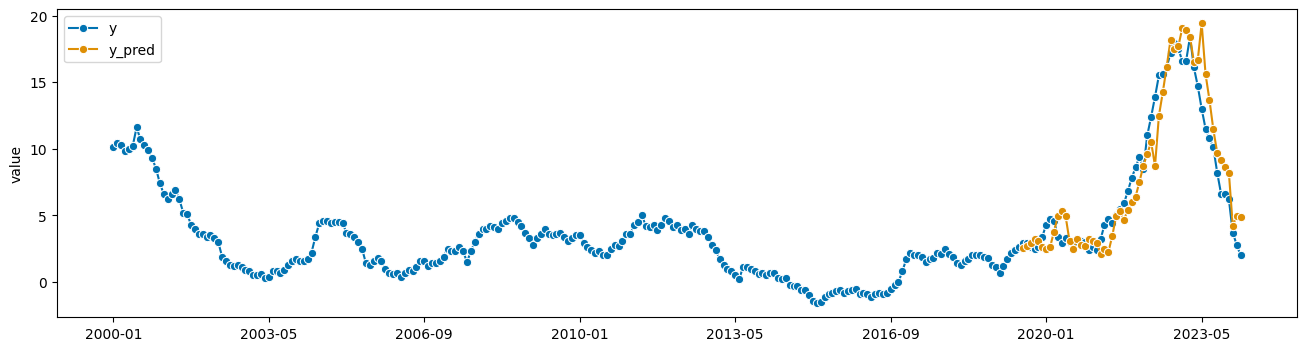


Anderson-Darling test for normal distribution: 0.40
Assuming significance level of 5% distribution is normal

Ljung-Box test for autocorrelation in residuals
         lb_stat      lb_pvalue
1    284.449312   8.054541e-64
2    555.206254  2.744693e-121
3    809.701462  3.405645e-175
4   1046.481677  3.012465e-225
5   1263.120938  6.234343e-271
6   1457.583006  8.226975e-312
7   1628.165810   0.000000e+00
8   1775.827356   0.000000e+00
9   1901.276049   0.000000e+00
10  2005.521912   0.000000e+00


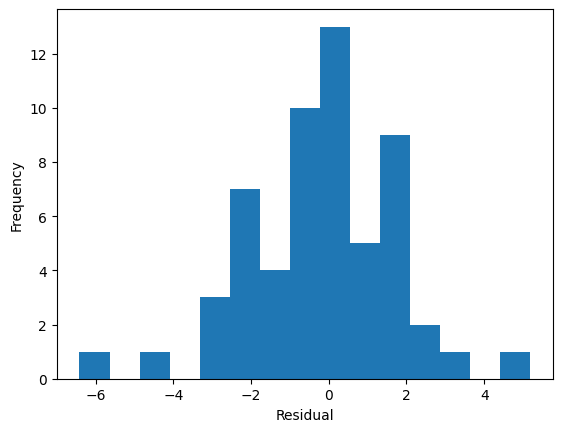

In [183]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS

fcr_aets = StatsForecastAutoETS(damped=True)
evaluate_model(model=fcr_aets, data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

MAE: 1.68 | SMAPE: 0.25 | MASE: 4.94


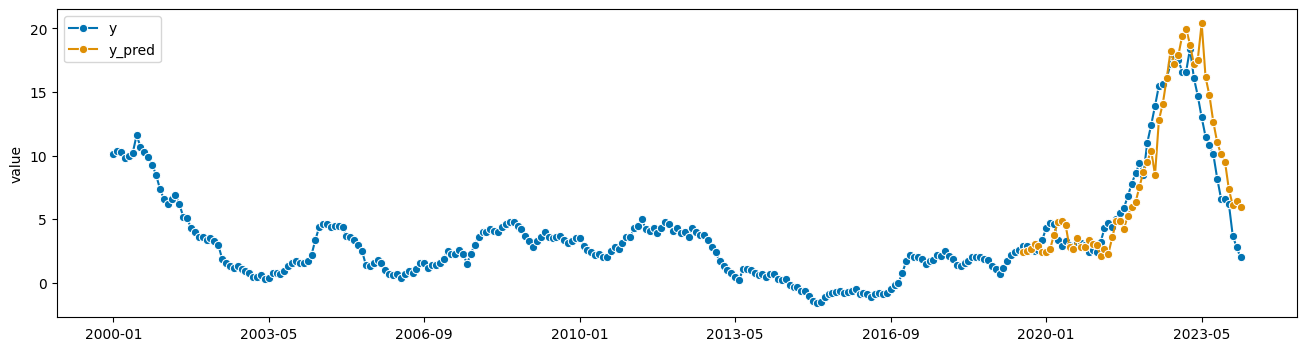


Anderson-Darling test for normal distribution: 0.74
Assuming significance level of 5% distribution is not normal

Ljung-Box test for autocorrelation in residuals
         lb_stat      lb_pvalue
1    284.449312   8.054541e-64
2    555.206254  2.744693e-121
3    809.701462  3.405645e-175
4   1046.481677  3.012465e-225
5   1263.120938  6.234343e-271
6   1457.583006  8.226975e-312
7   1628.165810   0.000000e+00
8   1775.827356   0.000000e+00
9   1901.276049   0.000000e+00
10  2005.521912   0.000000e+00


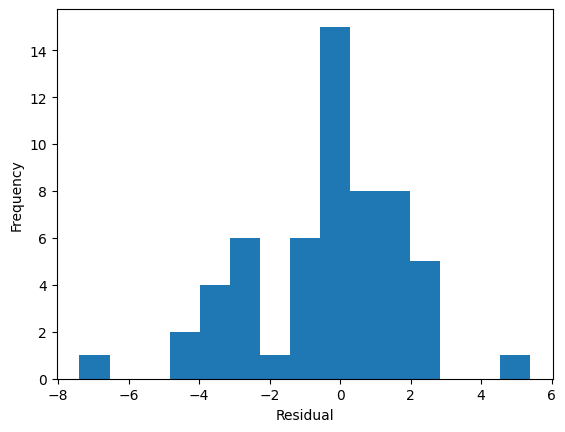

In [184]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

fcr_aarima = StatsForecastAutoARIMA(seasonal=False)
evaluate_model(model=fcr_aarima, data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

// skomentuj tutaj

Tak udało się przebić baseline, przy czym lepszym modelem okazał się ETS, co może oznaczać iż
zależności w danych nie są bardzo złożone. Modele są w przybliżeniu poprawne. Wyniki najlepszego
modelu są wystarczająco dobre do przewidywania ogólnego zachowania inflacji, ale do szczegółowych
analiz mogą być za słabe.

Prognozowanie 3-miesięczne było jednak dość krótkim horyzontem czasowym. Pytanie, co z dalszymi - półrocznym i rocznym. Są one często równie, albo nawet bardziej interesujące, np. w kontekście planowania budżetowego.

**Zadanie 5 (0.75 punktu)**

Dokonaj prognoz dla 6-miesięcznego oraz rocznego horyzontu:
- 2 baseline'ami
- metodami ETS oraz ARIMA
- dla najlepszego modelu narysuj prognozy oraz dokonaj analizy błędów

Skomentuj:
- czy widać jakieś zmiany między modelami w stosunku do przypadku 3-miesięcznego?
- jak zmienia się jakość prognoz przy większych horyzontach czasowych?
- czy te modele dla dłuższych horyzontów są twoim zdaniem użyteczne?

In [185]:
fcr_mean = NaiveForecaster(strategy="mean", window_length=3)
fcr_last = NaiveForecaster(strategy="last")
fcr_aets = StatsForecastAutoETS(damped=True)
fcr_aarima = StatsForecastAutoARIMA(seasonal=False)

print("Naive mean")
evaluate_model(model=fcr_mean, data=df, horizon=6, plot_forecasts=False, analyze_residuals=False)

print("\nNaive last")
evaluate_model(model=fcr_last, data=df, horizon=6, plot_forecasts=False, analyze_residuals=False)

# print("\nAutoETS   ")
# evaluate_model(model=fcr_aets, data=df, horizon=6, plot_forecasts=False, analyze_residuals=False)

print("\nAutoARIMA ")
evaluate_model(model=fcr_aarima, data=df, horizon=6, plot_forecasts=False, analyze_residuals=False)

Naive mean
MAE: 3.70 | SMAPE: 0.47 | MASE: 10.96

Naive last
MAE: 3.30 | SMAPE: 0.42 | MASE: 9.80

AutoARIMA 
MAE: 3.36 | SMAPE: 0.41 | MASE: 9.93


MAE: 2.93 | SMAPE: 0.38 | MASE: 8.72


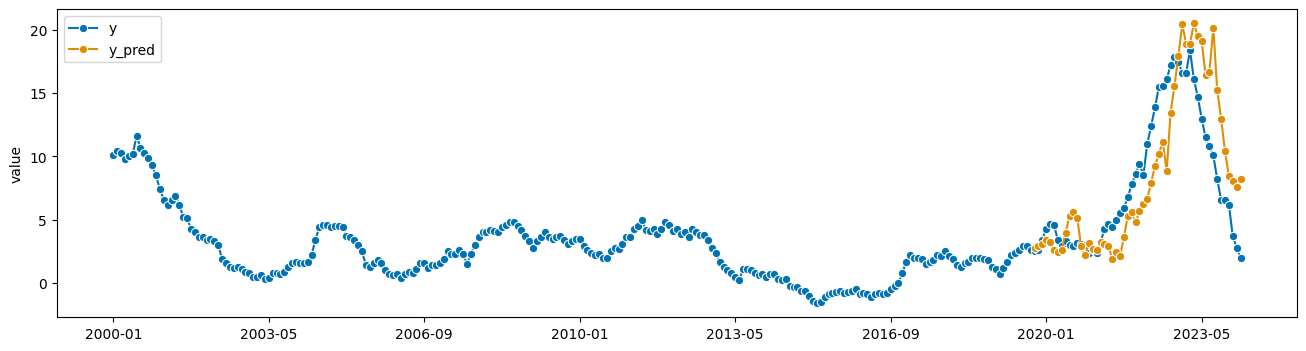


Anderson-Darling test for normal distribution: 0.58
Assuming significance level of 5% distribution is normal

Ljung-Box test for autocorrelation in residuals
         lb_stat      lb_pvalue
1    284.449312   8.054541e-64
2    555.206254  2.744693e-121
3    809.701462  3.405645e-175
4   1046.481677  3.012465e-225
5   1263.120938  6.234343e-271
6   1457.583006  8.226975e-312
7   1628.165810   0.000000e+00
8   1775.827356   0.000000e+00
9   1901.276049   0.000000e+00
10  2005.521912   0.000000e+00


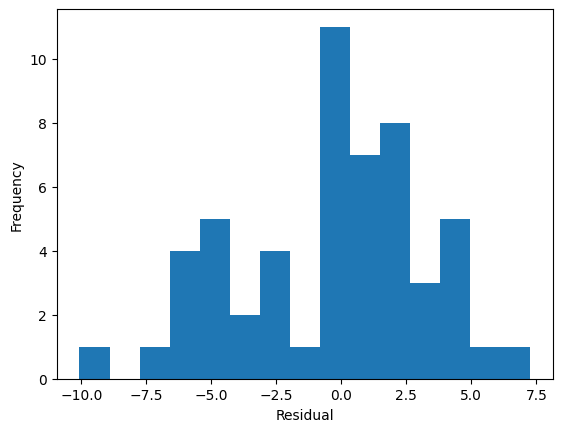

In [186]:
fcr_aets = StatsForecastAutoETS(damped=True)
evaluate_model(model=fcr_aets, data=df, horizon=6, plot_forecasts=True, analyze_residuals=True)

// skomentuj tutaj

Nadal najlepszym modelem jest ETS, przy czym zarówno ARIMA i ETS przebijają baseline. Zgodnie z
oczekiwaniami przy dłuższym horyzoncie predykcji jakość prognoz maleje i mamy ok. 2x większe
wartości MAE. Dla takich horyzontów predykcji błędy modeli są według mnie za duży, aby mogły być
użyteczne.

## Prognozowanie ruchu sieciowego

Teraz zajmiemy się problemem o zupełnie innej charakterystyce - prognozowaniem ruchu sieciowego. Jest to kluczowe zadanie pod kątem skalowania serwerów, coraz częściej realizowane z pomocą właśnie prognozowania szeregów czasowych. Tzw. predictive scaling implementują między innymi [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling) i [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive), istnieją także rozwiązania dla Kubernetesa, [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/), oraz [komercyjne](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Prognozowanie szeregów czasowych pozwala proaktywnie dokładać kolejne maszyny wirtualne, aby przygotować się na zwiększony ruch i zapewnić niskie opóźnienia, oraz redukuje koszty, automatycznie wyłączając je przy przewidywanym małym ruchu.

Wikipedia i Google hostowały [konkurs na platformie Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting), w którym zadaniem było prognozowanie ruchu na poszczególnych stronach. Jest on dość kolosalny, dlatego na jego podstawie przygotowano uproszczony, w którym mamy zapisaną sumaryczną liczbę requestów do Wikipedii, liczoną w milionach.

Charakterystyki takiego zadania to typowo:
- krótkoterminowe prognozy
- duża częstotliwość danych
- dynamicznie zmienne i zaszumione dane (np. przez aktywność botów)
- bardzo częsty retrening modeli
- duża potrzeba automatyzacji, brak ręcznej analizy modeli

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


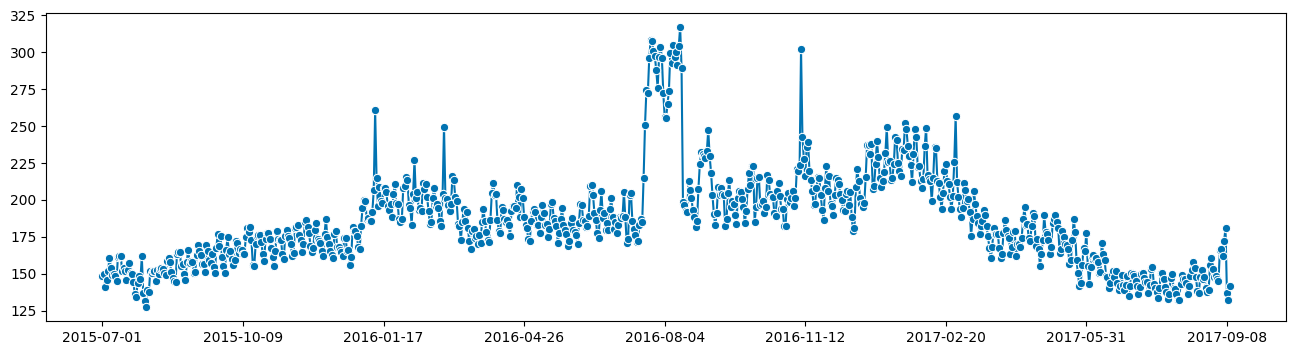

In [187]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
plot_series(df)
df

**Zadanie 6 (1 punkt)**

Zakładając horyzont 1 dnia, wytrenuj modele i dokonaj ich ewaluacji (analogicznie do poprzedniego zbioru danych):
- 2 modele baseline'owe
- model ETS (z damped trend)
- model ARIMA (bez sezonowości)
- model SARIMA

Skomentuj:
- czy z tych wyników można wnioskować, że mamy tu sezonowość?
- czy udało się przebić baseline?

Może jednak da się lepiej? Nasze dane mają bardzo dużą zmienność, a więc wariancję, a modele ARIMA tego nie lubią. Zastosujmy więc transformacje stabilizujące wariancję. Mamy tu same dodatnie wartości, więc nie będzie tu problemów numerycznych i można używać dowolnych operacji.

Trzeba tutaj wykorzystać `Pipeline` z sktime, bo automatycznie odwróci on wszystkie operacje podczas predykcji. Czasem dokonuje się ewaluacji danych po transformacji, ale typowo interesuje nas jakość na pierwotnych danych. Przekształcenia służą tylko do poprawienia treningu.

**Zadanie 7 (0.5 punktu)**

Stwórz pipeline, składający się z transformacji oraz modelu AutoARIMA (bez sezonowości). Wypróbuj transformacje:
- log
- sqrt
- Box-Cox

Przedstaw na wykresie oraz pierwotny szereg czasowy szereg po transformacji dającej najlepszy wynik.

Funkcję `make_pipeline` oraz klasy implementujące transformacje znajdziesz w sktime.

Skomentuj:
- czy udało się poprawić wynik transformacją?
- oceniając wizualnie, czy udało się ustabilizować wariancję?

## Prognozowanie sprzedaży

Najpowszechniejszym zastosowaniem prognozowania szeregów czasowych jest przewidywanie zapotrzebowania, sprzedaży, popytu, wydatków etc., czyli wszystkich typowych wskaźników dla przedsiębiorstwa. Musi to robić zasadniczo każda firma, dlatego nawet Excel oferuje rozbudowane możliwości prognozowania szeregów czasowych.

Zajmiemy się teraz kluczowym zadaniem dla włoskiej gospodarki, jakim jest prognozowanie sprzedaży makaronu. Zbiór danych został zebrany przez włoskich naukowców na potrzeby [tego artykułu naukowego](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Dane pochodzą z lat 2014-2018 (do końca roku), z 4 firm, i dotyczą wielu wyrobów z makaronu. Zawierają też dane o promocjach na poszczególne produkty. Niektórych danych brakuje, i wartości te trzeba imputować.

Dane tego typu mają typowo następujące cechy:
- często trend rosnący, mniejszy lub większy
- mocną sezonowość, często więcej niż jedną
- dużą czułość na powtarzalne okazje, np. weekendy czy święta
- duże i powtarzalne outliery
- dość duży szum i zmienność
- relatywnie niską częstotliwość, dzienną lub niższą
- często długie horyzonty dla prognozowania: miesięczne, kwartalne czy roczne
- zmienne egzogeniczne

**Zadanie 8 (1 punkt)**

1. Wczytaj dane z pliku `"italian_pasta.csv"`
2. Wybierz kolumny z firmy B1 (mają `"B1"` w nazwie) oraz kolumnę `"DATE"`
3. Stwórz kolumnę `"value"`:
   - sumaryczna sprzedaż makaronu
   - suma kolumn z `"QTY"` w nazwie
4. Stwórz kolumnę `"num_promos"`:
   - sumaryczna liczba aktualnych promocji
   - suma kolumn z `"PROMO"` w nazwie
5. Pozostaw tylko kolumny `"DATE"`, `"value"` oraz `"num_promos"`
6. Stwórz indeks typu datetime:
   - zmień typ kolumny `"DATE"` na datetime
   - ustaw tę kolumnę jako indeks
   - ustaw jej częstotliwość (frequency) jako dzienną, `"d"`
7. Podziel dane na:
   - zmienną `y`, `pd.Series` z kolumny `"value"`, główny szereg czasowy
   - zmienną `X`, `pd.Series` z kolumny `"num_promos"`, zmienne egzogeniczne
8. Uzupełnij wartości brakujące w zmiennych egzogenicznych zerami - możemy założyć, że domyślnie nie ma promocji.
9. Przedstaw na wykresie szereg czasowy `y`. Pamiętaj o podaniu tytułu wykresu.

Tym razem będzie nas interesowało prognozowanie w długim horyzoncie czasowym. Zakładamy, że nasz klient, włoski producent makaronu, ma dane z lat 2014-2017, i chce prognozować swoją sprzedaż w roku 2018. Takie prognozy są potrzebne np. do zakontraktowania długoterminowych dostaw i produkcji na kolejny rok. Z naszej perspektywy jest to trudne, ale przynajmniej szybkie, bo mamy tylko jeden zbiór treningowy i testowy, a nie serię, jak w expanding window.

Do ewaluacji posłuży nam teraz funkcja `evaluate_pasta_sales_model`.

**Zadanie 9 (1 punkt)**

Uzupełnij kod funkcji do ewaluacji:
- podziel `y` na zbiór treningowy i testowy według daty, wszystko od `2018-01-01` włącznie to zbiór testowy
- jeżeli przekazano `X`, to je tak samo podziel
- dokonaj imputacji wartości brakujących w `y`:
  - klasa `Imputer` z sktime
  - zastosuj strategię `ffill` (uzupełnienie ostatnią znaną wartością)
- wytrenuj model (pamiętaj o przekazaniu `X`), dokonaj predykcji
- dokonaj ewaluacji predykcji za pomocą MAE, SMAPE oraz MASE (znajdź odpowiednie funkcje w sktime)
- wypisz wyniki do 2 miejsca po przecinku
- skopiuj kod dla `plot_forecasts` i `analyze_residuals` z zadania 3

In [188]:
from typing import Optional

import numpy as np
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    df: pd.Series,
    X: Optional[np.ndarray] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    # split data

    # impute values

    # fit, predict, calculate and print metrics

    # plot_forecasts

    # analyze_residuals
    ...

Teraz nie pozostaje nam nic, tylko prognozować.

**Zadanie 10 (1.5 punktu)**

Dokonaj predykcji modelami:
- 2 baseline'ami
- ETS (z damped trend)
- ARIMA
- SARIMA z sezonowością 30 dni
- ARIMAX
- SARIMAX z sezonowością 30 dni

Dla najlepszego modelu wypróbuj transformacje log, sqrt oraz Box-Cox.

Na koniec narysuj predykcje oraz dokonaj analizy błędów dla finalnego modelu.

Skomentuj:
- czy udało się przebić baseline?
- czy finalny model uwzględnia sezonowość i/lub zmienne egzogeniczne (dane o promocjach)?
- czy warto było stosować transformacje danych?
- skomentuj ogólne zachowanie modelu na zbiorze testowym, na podstawie wykresu predykcji
- czy model jest nieobciążony (rozkład normalny błędów o średniej 0), bez autokorelacji, czy jest tutaj miejsce na poprawę?

Zmienne egzogeniczne można jeszcze rozbudować - przykładowo, zachowanie kupujących w weekendy i święta jest inne. Typowo sprzedaż mocno rośnie przed i po okresach, kiedy sklepy są zamknięte, no i naturalnie spada do zera, kiedy sklep jest nieczynny.

**Zadanie 11 (0.75 punktu)**

1. Stwórz listę zmiennych reprezentujących święta z pomocą klasy `HolidayFeatures`:
   - przyda się funkcja `country_holidays` z biblioteki `holidays`
   - pamiętaj o tym, że operujemy we Włoszech, skrót kraju `"IT"`
   - uwzględnij weekendy
   - stwórz po prostu jedną zmienną "czy jest święto" (opcje `return_dummies` i `return_indicator`)
2. Dodaj te zmienne do naszych danych o promocjach `X`. Przyda się `pd.merge` oraz opcje `left_index` i `right_index`.


## Zadanie dodatkowe (3 punkty)

Klasyfikacja szeregów czasowych często wykorzystuje dane z akcelerometrów, smartfonów, smartwatchy i innych tego typu urządzeń. Praktycznie każdy wyżej klasy smartwatch ma wbudowane proste klasyfikatory analizujące aktywność, tętno, ruch itp. Ciekawym zastosowaniem miary takiej aktywności dobowej jest diagnostyka medyczna, bo niektóre choroby powodują nieoczywiste na pierwszy rzut oka zmniejszenie motoryki człowieka.

[Zbiór danych Depresjon](https://datasets.simula.no/depresjon/) dotyczy diagnozy depresji na podstawie aktywności dobowej mierzonej smartwatchem ActiGraph. Zbiór ze względu na wrażliwą naturę problemu jest bardzo mały, 55 pacjentów, ale trzeba sobie z tym radzić, bo w medycynie jest to dość normalne. Pomiary per pacjent są dość długie, około 2 tygodni.

1. Wczytaj dane, upewnij się że mają prawidłowe typy
2. Uzupełnij wartości brakujące per pacjent za pomocą interpolacji liniowej (klasa `Imputer`)
3. Do ewaluacji wykorzystaj podejście z [tego artykułu](https://www.cai.sk/ojs/index.php/cai/article/view/2021_4_850), tzw. nested cross-validation:
   - 5-fold CV (stratified) do testowania (outer)
   - LOOCV do wyboru hiperparametrów (inner)
4. Dokonaj ekstrakcji cech algorytmami:
   - [MiniROCKET](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.MiniRocket.html)
   - [Shapelet transform](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.shapelet_transform.ShapeletTransform.html)
   - [TSFRESH](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.tsfresh.TSFreshRelevantFeatureExtractor.html) (w wariancie "efficient")
   - [Catch22](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.catch22.Catch22.html)
5. Wykorzystaj regresję logistyczną (`LogisticRegressionCV`) jako klasyfikator
6. Dokonaj ewaluacji za pomocą metryk:
   - balanced accuracy
   - F1
   - precision
   - recall
   - specificity
   - AUROC
   - MCC (Matthews Correlation Coefficient)
7. Porównaj wyniki z [artykułem](https://www.cai.sk/ojs/index.php/cai/article/view/2021_4_850) (tabela 4). Skomentuj, czy udało się przebić te wyniki.